# Курсовой проект для курса "Python для Data Science"

# Info

Материалы к проекту (файлы): train.csv test.csv

Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)


Подключаем нужные нам библиотеки.

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Отключаем предупреждения.

In [2]:
import warnings
warnings.filterwarnings('ignore')

Задаём везде одинаковый размер шрифта.

In [3]:
matplotlib.rcParams.update({'font.size': 14})

Пишем функцию для подсчёта метрик - будем подсчитывать метрику R2 на обучении, на тесте. И будем рисовать два графика - качество предсказания на обучении и качество предсказания на тесте.

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

1. Загрузка и анализ данных:

In [5]:
DATA_TRAIN_PATH='train.csv'
DATA_TEST_PATH='test.csv'
RESULT_PATH='sample_submission.csv'
data=pd.read_csv(DATA_TRAIN_PATH)
X_test=pd.read_csv(DATA_TEST_PATH)

Описание датасета

- Id  - идентификационный номер квартир
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [6]:
train_df = pd.read_csv(DATA_TRAIN_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [7]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
test_df = pd.read_csv(DATA_TEST_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [9]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [10]:
train_df.shape[1]-1 == test_df.shape[1]

True

In [11]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


Id и DistrictId переводим его  в строковый тип данных. 

In [12]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

Изучение целевой переменной. Она вещественная, задача регрессии - предсказывать непрерывную величину. Когда целевая переменная непрерывная, то стоит изучить её график распределения и почитать меры центральной тенденции, посмотрим только на распределение.

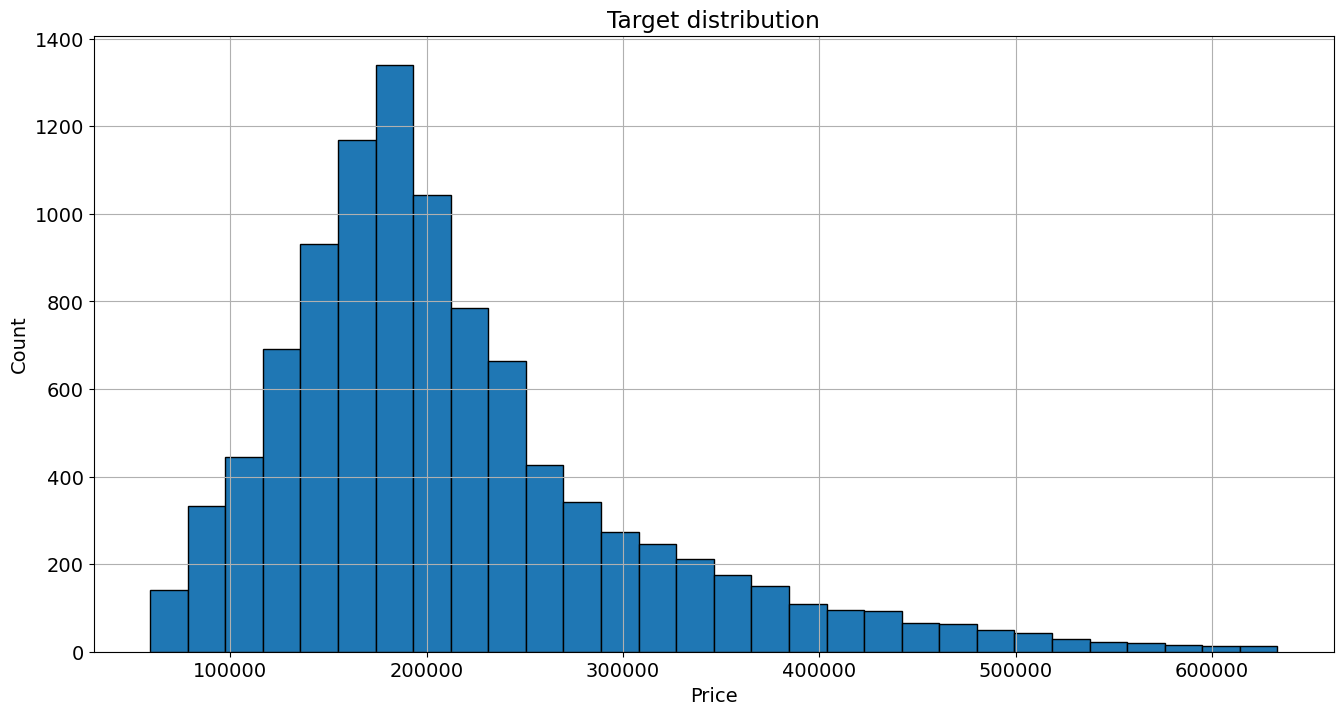

In [13]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30, edgecolor='black')
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Здесь получается, что дешёвых квартир мало, квартир, которые стоят по среднему много, а дорогие квартиры это хвост, уходящий вправо. Всё это похоже на правду, поэтому изучем дальше и смотрим уже на признаки.

Когда изучаются вещественные признаки, то обязательно надо посмотреть на основные статистики с помощью describe(). Во-первых можно понять где есть пропуски, с помощью count - если здесь не 10000, значит есть пропуски. Далее подсчитываеться средняя mean, а вот среднюю стоит сравнивать с медианой 50%, потому что если они отличаются, значит где-то есть выбросы. Так же здесь стоит посмотреть на минимальные - максимальные значения. 

In [14]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


count - норм. - 10000; LifeSquare - 7887 - есть пропуски; mean - Social_3 - 8.039200, 50% - Social_3 - 2.000000, - разница в 4 раза; min - Rooms - 0; max - LifeSquare - 7480.592129; KitchenSquare - 2014.000000 - очень много.

In [15]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

Всего уникальных районов - 205, при этом есть очень населённые, где квартир встречается много, а есть где по одной квартире. Дальше с этим признаком нужно работать как с категорией, лучше его перевести во что-то вещественное, т.к. нельзя сказать, что 27 район это больше чем 1-ый, или 174 район больше чем все прочие. Для этого нужно переводить либо в бинарные признаки, либо описывать категорию другим вещественным признаком, либо описывать эту категорию через целевой признак, это Target encoding, но есть ещё один подход - можно признак описать через себя же, через value_counts() - тут каждое значение в нем подсчитывается, в 27 р-не 851 кв., а в 1-ом р-не 652 кв., с точки зрения математики 851 > 652 > 1, получается, что посчитаные значения кол-ва квартир в каждом районе можно сравнивать между собой. Значит такую кодировку можно использовать для перевода категории во что-то вещественное.

Есть и другие строковые признаки - у них по две категории, поэтому их без проблем можно перевести в бинарные признаки. Потому что будет один признак, только в бинарном представлении.

In [16]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [17]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [18]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

В этих строчках гораздо больше объектов со значением B и гораздо меньше объектов со значением A, что-бы они не значили.

2. Обработка выбросов

Что можно делать с ними?

Выкинуть эти данные, либо весь признак выбросный, либо весь объект выбросный (только на трейне, на тесте ничего не выкидываем)
Заменять выбросы разными методами (медианы, средние значения, делать левую границу, правую границу с промощью np.clip, разные группировки заполнять выбросы, либо вообще обучать модель на заполнение выбросов и пропусков и т.д.)
Делать/не делать дополнительный признак (фичу), который говорит, что в этом объекте, в этом признаке был выброс. Новые признаки делать везде.
Ничего не делать

Первый признак кол-во комнат. Сделаем value_counts() - посчитаем сколько уникальных значений встречается в нашем датасете.

In [19]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Чаще всего встречаются квартиры с двумя комнатами. Есть 1, 3, 4, 5 и 0 комнат,возможно это студии, так что 0 - это студия, а в ней по факту одна комната. Есть так же 10, 19 и 6. Если ещё в 5 и 6 комнат могут существовать, то в 10 и в 19 нет. Т.ч. это скорее всего какие-то выбросы, и их нужно обрабатывать.

Сделаем признак,указывающий, что в кол-ве комнат есть выбросы, признак равен 0, но там где признак стоит равный == 0, либо кол-во комнат >= 6, то мы этот признак заменяем на = 1. Делаем пометку 'Rooms_outlier', означающую, что в этих признаках, вот в этих объектах находиться выброс и его пометили 1.

In [20]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


Там где кол-во комнат == 0 ставим 1, а так где >=6 мы ставим - .median().

In [21]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [22]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

Теперь признак Rooms принял меньшее кол-во значений, и они более адекватные.

Следующий признак - это площадь кухни, посмотрим сначала сколько уникальных значений и как часто встречаются они.


In [23]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

На первом месте 1 кв.метр на кухню, есть 0 кв.м, есть 3кв.м чисто физически, что на 2-х кв.м, что на 1-ом кв.м на кухне не уместишься, но помимо маленьких значений есть и большие - 112 кв.м, есть 2014 кв.м, есть 1970 кв.м. Поэтому здесь воспользуемся универсальным подходом - с помощью .quantile(). Посчитаем quantile(.975)%

In [24]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

Так как quantile(.025) здесь получился 0 кв.м, а 0 кв.м это не адекватно, поэтому потом возьмём 3 кв.м. И если пл.кухни больше 13 кв.м, то будем считать это выбросом по quantile(.975).

Пропишем условие, что если площадь кухни пропуск - .isna(),либо пл.кухни больше заданного .quantile(.975) - больше 13 кв.м, то по данному условию, меняется значение в пл.кухни на медиану .median(). Так обработаем верхнюю границу, если очень большая площадь кухни, а нижнюю границу обработаем по условию меньше < 3 кв.м , если пл.кухни меньше 3 кв.м мы её меняем на 3 кв.м. Вот такая минимальная граница будет по площади кухни.

In [25]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

И проверяем.

In [26]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

Вот теперь уникальных значений стало меньше. Они уже сами по себе тоже стали маленькими.

Переходим к признакам связанных с этажами где стоят квартиры и с этажностью дома в целом, в к-ром эти кв. находятся. Смотрим на уникальные значения.


In [27]:

train_df['Floor'].sort_values().unique()


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

Здесь адекватные значения.

In [28]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

Вот есть дом с 0 этажей, есть с 99, а есть с 117-ю. данные по Москве, но всё равно это не адекватные признаки. Это выбросы.

In [29]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

Тут есть проблема, что есть этажи, к-рые больше этажности, и их много,1825 штук, примерно 1/5 часть данных.

Сначала сделаем дополнительный признак показывающий, что с этажами было что-то не в порядке, и если этажность в доме равна 0, то ставим 1, делаем метку; и если этажи находятся выше этажности домов, то такое тоже помечаем 1.

In [30]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

Там где этажность равна 0 - меняем значение на median().

In [31]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

И теперь поработаем с квартирами где этаж больше этажности.

In [32]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

Возьмём индексы этих объектов их уже стало меньше 1610.(когда мы 0 этаж поменяли на median() то несколько квартир попали в дом, под крышу), но много неадекватных значений осталось, их с помощью random.randint, можно в случайное место запихнуть квартиру. Взять объекты по этим индексам 'Floor', где этаж больше этажности, взять в этих объектах признак этажности 'HouseFloor' эту цифру, и случайно взять этаж от 1 до этажности (1, x).

In [33]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

Вот в случайное место в доме положили квартиру.

In [34]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

И вот после такой обработки становиться неадекватных объектов - 0. Что, в принципе, идеально.

Смотрим на признак постройки домов.

In [35]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

Здесь есть два очень больших значения - 20052011, это скоре всего период постройки, с 2005 по 2011, и есть дом из будущего - 4962 года, но тут навярняка 4 спутали с 1, когда такая ситуация в данных - 1,2 объекта неадекватные лучше делать универсальную замену, сравнивая с максимальным, адекватным годом, и если у нас есть объекты, где год постройки больше самого максимального адекватного года, типа 2021, то заполнять его на 2021.

In [36]:
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear'] = 2021

3. Обработка пропусков

In [37]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

Тут есть два признака с пропусками это LifeSquare - 2113 и Healthcare_1 - 4798.

Начнём с жилой(LifeSquare), помимо жилой площади есть общая и площадь кухни. Соответственно можно воспользоваться всей площадью(Square) и пл. кухни(KitchenSquare) что бы заменить пропуски жилой пл. Совершенно логично, что если взять всю площадь, вычесть из неё пл.кухни и вычесть из неё что-то нежилое - разные корридоры, балконы, кладовки, туалеты, то в потенциале получим жилую площадь

In [38]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,3.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,3.0
9,79.867477,75.085125,3.0


Сделаем метку этого признака, что там был пропуск. 1 - если пропуск есть, 0 - если пропуска нет. Далее напишем условие, что если в жилой пл. есть пропуск, и при этом пропуска нет во всей пл. и в пл. кухни, то мы по этому условию будем находить разницу между всей пл., пл. кухни , и какими-нибудь 3 кв.м на всё -про-всё нежилое. вот таким образом будем получать жилую площадь зная всю пл. , пл.кухни, и -3кв.м на балконы, кладовки и т.д.

In [39]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

И ещё есть Healthcare_1, в котором есть пропуски. Ну там пропусков очень много, практически половина объектов - это пропуски, то такое, в принципе можно выкинуть.

In [40]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

Итак, обработали данные, но что бы все эти обработки применить и к валидации, и к тестовому набору данных нужно все эти обработки оформить в виде класса или функции, что б это было принимимо ко всем новым датасетам. Соответственно оформляем наш class DataPreprocessing, здесь будет происходить вся подготовка данных

In [41]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

4. Построение новых признаков

Давайте прогенерируем новые признаки. Начнём с перевода категории во что-то вещественное.

Имеем категории 'Ecology_2', 'Ecology_3' и 'Shops_2' - там всего лишь два уникальных значения, которые легко переводятиься в 0 и 1. Из А в 0, из В в 1 - мы получаем новые бинарные признаки. Это можно делать с помощью словаря, который мы передаём в .replace() - значения меняются и становяться бинарными признаками.

In [42]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

DistrictId - это DistrictId района, мы меняем его с помощью .value_counts() на подсчитанные квартиры - сколько находиться в каждом районе. Готовим небольшой датафрейм, переменуем колонки из индекса на DistrictId, а потом кол-во объектов, сколько было во всех этих районах мы переменуем на DistrictSize.

In [43]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


Получилась такая вспомогательная таблица перевода из категории во что-то вещественное, к-ую надо использовать для кодирования всех категорий района. Присоединяем обучаещёму датасету эту вспомогательную таблицу.

In [44]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,3097,0,0,0,1,305018.871089,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1,0,1,177734.553407,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,3,1,1,282078.720850,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,264,0,0,1,1,168106.007630,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,0,6,1,343995.102962,0,0,0,89


Вот тут показано что первый район 27 он описывается цифрой 851, её видим в новой колонке DistrictSize. Далее можно убрать признак DistrictId из обучения и обучаться только на DistrictSize.

Вот таким образом перевели из категории во что-то вещественное через описание признака через самого себя.

Сделаем ещё один признак - бинарный - большой или небольшой район. Условно будем считать, что если в районе более ста квартир, то это большой район, если меньше, то значит это будет маленький район.

In [45]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [46]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

Самыми полезными признаками считаются Target encoding это когда целевую переменную кодируем через другие признаки. Здесь предсказыаем стоимость квартиры и логично что стоимость квартиры варьируется как зависимость от района и кол-ва комнат, поэтому сделаем группировку от района и от кол-ва комнат, посчитаем медианую целевую переменную. И так же её переименуем, что бы не было наслоения одинаковых наименований колонок.

In [47]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


Здесь для всех уникальных значений DistrictId, для всех уникальных значений Rooms подсчитались в MedPriceByDistrict, т.е. если квартира находится в 0 районе, имеет 1 комнату,, то стоимость будет 142к... при этом если 1 комн. кв. в 1 районе, то ст. - 146к... Т.е. в зависимости от района, от кол-ва комнат действительно целевая переменная изменяется.

In [48]:
med_price_by_district.shape

(667, 3)

667 уникальных значений у нас получилось и теперь такую вспомогательную таблицу, к-ая в себе содержит кодирование для нового признака, присоединяем исходному датасету. Соеденяем её уже по двум колонкам.

In [49]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.871089,0,0,1,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,0,652,1,244005.272380
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,1,1,168106.007630,0,0,1,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,0,89,0,201584.441255


получается, что ...в 1 районе 1 комн. кв. имеет новый признак - 146к.., вот такой новый интересный полезный признак, к-ый в себе содержит целевую переменную.

Так как Target encoding это очень полезные признаки, то лучше делать их побольше. А т.к. Target encoding - это признаки основаные на группировке, а группировка имеет смысл только для категорий, то если делать Target encoding на этажи и на года постройки - на вещественных признаках, то смысл кодировки потеряется. Поэтому вещ. признаки перед Target encoding переводить во что-то категориальное. Делать из вещ. признака - дискретный.

Переведём этаж в категорию и переведём год в категорию. Когда переводим в категорию сначала задаём новый признак и инициализируем его, к-ый везде равен 0, далее если этаж меньше или равен 3 это будет 1-ая категория, если больше 3 но меньше 5 = 2 кат., итд. И также желаемыми годами постройки мы заполняем наши категории. Вот так создавая границы можно менять категории, так же в него нужно передать признак. Соответственно по признаку пройдёмся этими интервалами и посмотрим куда они принадлежат.. также поставим labels=False, если на выходе появиться пропуск, его можно заменить любым значением, главное, чтобы оно не пересекалось с тем, что есть. Это будет новая категория для пропущенных значений.

In [50]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [51]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

И переводим из вещ.признака в категорию этаж и год.

In [52]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,1,305018.871089,0,0,1,851,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,177734.553407,0,0,0,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,282078.720850,0,0,0,652,1,244005.272380,4,1
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,168106.007630,0,0,1,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,343995.102962,0,0,0,89,0,201584.441255,3,5


И из этих категорий мы можем сделать Target encoding.Сделаем группировку по году, по этажу и считаем медиану целевой переменной. Так же делаем переименование, что б наши колонки не наслаивались с одинаковыми наименованиями.

In [53]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,380359.112959
1,1,2,321488.560449
2,1,3,429458.388683
3,1,4,274992.472366
4,2,1,467230.539057


И вот для всех уникальных значений категории года постройки, этажа квартиры у нас посчитались медианные целевые переменные, и теперь это соединяем с нашим исходным датасетом по двум признакам - по категориям года постройки, и этажам.

In [54]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,1,851,1,213530.788443,6,2,164803.070010
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,78,0,146032.829834,3,3,192358.129020
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,652,1,244005.272380,4,1,205708.069184
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,168106.007630,0,0,1,652,1,146735.671740,3,4,183536.270077
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,89,0,201584.441255,3,5,174368.821945


И снова всё это оформим в класс. Сначала задаём значения, к-ые вспомогательные, разные значения максимальных, максимального этажа, в целом наши датафреймы(df), к-ые будем использовать для дальнейшего соединения с исходными датасетами. Далее - метод fit, здесь всё подсчитывается, всё что необходимо, на всякий случай сделаем копию нашего датасета, что бы ничего в исходном наборе данных не поменялось. И начинаем с интилизации и с объявления нашей маски кодирования из А в 0, В в 1 для бинарных признаков. Далее здесь подсчитается df для перевода из категории района во что-то вещественное, и далее Target encoding. Если мы в fit подаём целевую переменную, значит навярняка эта выборка у нас обучающая, и значит можем посчитать Target encoding. И собственно их считаем - делаем группировку по DistrictId, по Rooms и считаем MedPriceByDistrict. И может такое случиться, что на тесте вдруг появиться новый DistrictId, и вдруг появиться новое кол-во Rooms. И получается группировка для нас у неё у нас не будет значений, тк группировка подсчитанна только на обучении, а то что придёт на тесте не знаем, не ожидаем... В этом случае после дальнейшего объединения появиться пропуск, и такое лучше заполнять той же медианой, медианой, к-ая посчиталась по новому признаку чтобы пропусков точно никаких не было. И считаем Target encoding для этажа и года постройки. Сначала берём макс. этаж на обучении, макс. год на обучении. Переводим этаж в категорию, год в категорию. Указываем наши желаемые категории до макс. этажа на обучении. И если на тесте приходит так, что этаж или год постройки больше макс. на обучении, то появиться пропуск, к-ый нужно заполнить с помощью .fillna(). Перевели из этажа в категорию и год в категорию и можно делать группировку. И на всякий случай - если вдруг появиться новая категория года или новая категория этажа, то такие пропуски лучше заполнять хотя бы медианой, к-ая подсчитана на новом признаке. Это в fit подсчитали все что только могли, все вспомогательные df, и вспомогательные словарики для перевода из строчки во что-то вещественное.

И теперь в transform всё это применяем. Сначала делаем перевод из строковых признаков в бинарные, далее соединяем df с размерами районов - это кодирование из строчки из категории DistrictId во что-то вещественное. и вот тут при .merge() может возникнуть новый объект на тесте, именно новый район на тесте, и когда присоеденим новый тестовый набор со старой табличкой подготовленного df, то может появиться пропуск. Сделаем метку, что если район не новый = 0, что если район новый, и если при объединении DistrictSize появиться пропуск мы заполняем 1. Это мы пометили новые районы. И при объединениии у нас остался пропуск его можно заполнить хотя бы 5. И делаем новый признак показательный, что район большой. бинарный признак 0;1.

Перед тем как добавить новый признак Target encoding, к-рый основан на этаже и году постройки, переводим этаж в кат., год в кат. И если df есть с подсчитанными Target encoding, то мы их присоединяем, а они у нас будут если в методе fit мы туда передаём целевую переменную. В fit всё подсчиталось и в этом df MedPriceByFloorYear у нас что-то хранится. Если оно есть то мы его присоединяем. Делаем DistrictId по Rooms и если вдруг появляется новое значение DistrictId, то мы уже готовы заполнить пропуски медианой, к-ую подсчитали тоже в fit. И по аналогии Target encoding для этажа и году постройки. Тоже это соединяем по двум признакам и если есть пропуски - заполняем.

In [55]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

5. Отбор признаков

Небольшой отбор признаков. Смотрим на чём хотим обучаться.

In [56]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

Обучаемсяся на всём, кроме DistrictId, потому что закодировали DistrictId через DistrictSize, кроме Id, так же на переводе из вещ.признаков в категорию по году и по этажу (year_cat,floor_cat)(признаки вспомагательные для создания Target encoding).

Выделяем два списка - первый для фичей базовых(feature_names), к-ые были, и название фичей новых(new_feature_names), к-ые придумали и целевая переменная (target_name = 'Price')

In [57]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['HouseFloor_outlier','LifeSquare_nan',  
                     'IsDistrictLarge',  'MedPriceByFloorYear', 'DistrictSize' ]

target_name = 'Price'

После предсказаний на обучении и на валидации рассмотрели таблицу важности признаков и избавились от бесполезных признаков (Rooms_outlier, HouseYear_outlier, new_district) и ооочень полезных - MedPriceByDistrict.

6. Разбиение на train и test

Считаем заново обучающую выборку, тестовую выборку, и из обучения выделим отдельно признаки в Х и отдельно целевую переменную в Y.

In [58]:
train_df = pd.read_csv(DATA_TRAIN_PATH)
test_df = pd.read_csv(DATA_TEST_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

И сделаем разбиение на обучение и на валидацию. Соотношение 67 на 33, перемешаем, и зафиксируем random_state для воспроизводимости, что бы всегда разбиение было одинаковое и на обучение, и на валидацию

In [59]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

Иицилизируем class DataPreprocessing. Обучаем его на обучающей выборке. Т.е. у нас здесь в preprocessor будут лежать все вспомогательные значения.

In [60]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [61]:
preprocessor.medians

Id               8389.500000
DistrictId         35.000000
Rooms               2.000000
Square             52.621164
LifeSquare         32.679351
KitchenSquare       6.000000
Floor               7.000000
HouseFloor         13.000000
HouseYear        1977.000000
Ecology_1           0.075779
Social_1           25.000000
Social_2         5285.000000
Social_3            2.000000
Healthcare_1      920.000000
Helthcare_2         1.000000
Shops_1             3.000000
dtype: float64

In [62]:
preprocessor.kitchen_square_quantile

12.0

При preprocessor у нас подсчитались медианы для всех признаков (.medians). и так же у нас есть квантиль по площади кухни (.kitchen_square_quantile). Этими вспомогательными значениями мы можем пользоваться на всех последующих выборках - и на обучении, и на валидации, и на тесте.

В fit посчитали всё, что могли посчитать, а теперь заполняем пропуски и на тесте. медианами, к-ые посчитали на обучении, и пользуясь квантилью площади кухни для заполнения выбросов площади кухни, тоже к-рую мы подсчитали на обучении.

Когда такое преобразование сделали, стоит убедиться, что размерности датасетов совпадают. Везде по 22 признака. Одинаковое кол-во, что радует.

Иницилизируем class FeatureGenetator(), обучаем его на обучающей выборке, и применяем его уже ко всем нашим выборкам.

In [63]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

Можем посмотреть, что лежит в ячейке class FeatureGenetator().

In [64]:
features_gen.district_size

,DistrictId,DistrictSize
0,27,580
1,1,445
2,23,372
3,6,345
4,9,194
...,...,...
200,209,1
201,186,1
202,207,1
203,199,1


Этой вспомогательной таблицей пользуемся и на обучении, и на валидации, и на тесте. Но при этом её подсчитали только на обучающенй выборкке.Взяли объекты только с обучения, посмотрели на уник. объекты DistrictId, и сделали value_counts() по этим объектам. И теперь этой табличкой будем пользоваться на всех последующих выборках. Так же здесь есть и Target encoding. Медианая целевая переменная зависимости от района и кол-ва комнат. Тоже есть заготовка - табличка подсчитанная только на обучающей выборке. Мы взяли все уникальные DistrictId, уник. Rooms и посчитали группировку и у них целевую переменную взяли, и теперь данную табличку присоеденяем и к обуч., и к валидации, и к тесту.

На всех трёх выборках выбираем признаки на к-ых хотим обучаться.

In [65]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

На всякий случай смотрим, что пропущенных значений нет.

In [66]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

Данные подготовлены. Признаки сгернерированы. Можно обучать модель.

7. Построение модели

Здесь зафиксирован random_state=42, среднеквадратичная ошибка (mse), эмпирически высчиталось оптимально - число деревьев = 500, макс. глубина деревьев = 10, ограничение на число объектов в листьях = 4. Обучим модель на выборке для обучения.

In [67]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=10,
                                 min_samples_leaf=4,
                                 random_state=42,
                                 n_estimators=500
                                 )
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=10, min_samples_leaf=4,
                      n_estimators=500, random_state=42)

Сделаем предсказание на обучении и на валидации.

Train R2:	0.837
Test R2:	0.742


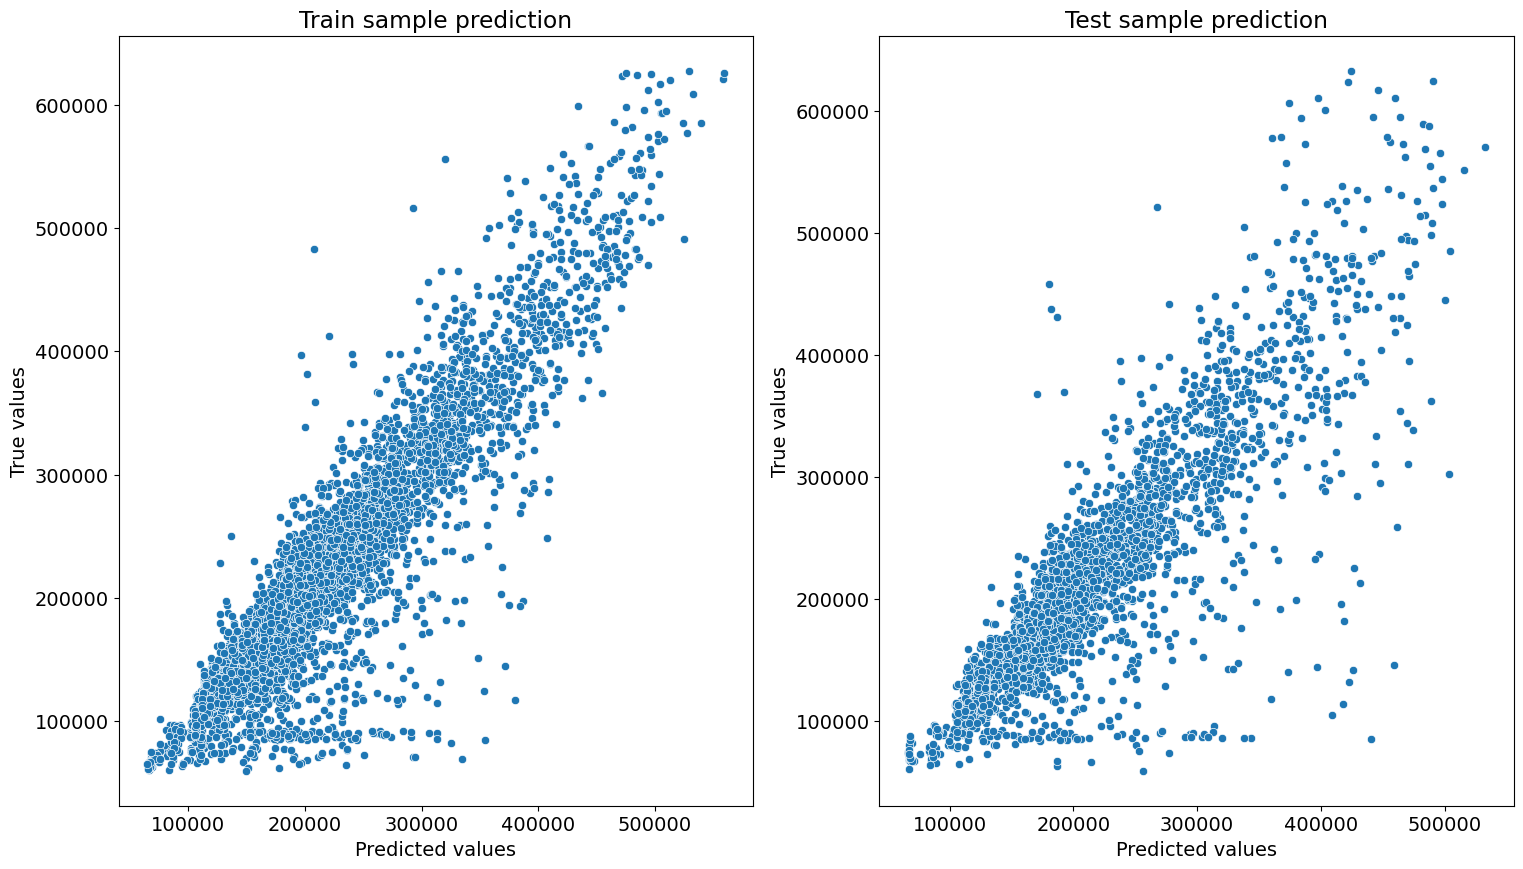

In [68]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Смотрим, что получается по метрикам. Train R2:0.838 - Test R2:0.74. == 0.09%. Неплохой результат, нужно было бы ещё поработать с признаками.

In [69]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.72203394, 0.69669479, 0.72554321])

In [70]:
cv_score.mean()

0.7147573148618883

На метрике видно - делая кросс-валидацию модели на обуч. выборке, по методу Р2, и кросс-валидацию на три хода, получаем три цифры, и их среднее -0.71. Эта цифра отличается от двух предыдущих.(0.838 и 0.74). В идеале, когда всё три цифры - метрика на обучении,на тесте, и на кросс-валидации стремяться к одному значению, это значит, что переобучение минимальное.

In [71]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.477444
20,DistrictSize,0.250569
12,Social_3,0.057135
7,Ecology_1,0.031800
11,Social_2,0.028159
0,Rooms,0.023991
10,Social_1,0.022595
2,LifeSquare,0.021140
19,MedPriceByFloorYear,0.019325
6,HouseYear,0.016152


8. Прогнозирование на тестовом датасете

In [72]:
test_df.shape

(5000, 21)

In [73]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,HouseFloor_outlier,LifeSquare_nan,IsDistrictLarge,MedPriceByFloorYear,DistrictSize
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,4378,0,1,1,1,0,0,0,188612.297808,76.0
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,629,1,0,0,0,0,0,1,180099.659745,164.0
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,1892,0,0,1,1,0,1,1,171621.224416,580.0
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,475,0,0,0,1,0,0,1,180344.164153,372.0
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,1,1,...,7715,4,0,6,1,0,1,0,192048.442631,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,2,5.0,1962,0.069660,1,1,...,6119,4,1,2,1,1,0,0,180344.164153,56.0
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,...,2787,2,0,7,1,0,0,0,199166.198392,26.0
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,6533,1,2,5,1,0,0,0,180344.164153,54.0
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,7976,5,0,11,1,0,0,0,192048.442631,40.0


In [74]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [75]:
predictions = rf_model.predict(test_df)
predictions

array([156035.45112788, 128460.39785283, 148589.42748562, ...,
       147693.5743218 , 195237.56838778, 266256.2485552 ])

In [76]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,156035.451128
1,5925,128460.397853
2,960,148589.427486
3,3848,131680.119984
4,746,225345.297186


In [77]:
submit.to_csv('rf_submit.csv', index=False)